# Intersection Graph Construction
To properly simulate bicyclist behavior, we need a graph that represents how a bicyclist can travel around a city. Idealy we will create a graph that models the interactions between road segemnts and intersections.

Intersections:
* A "fully connected" intersection must allow byclicts to leave any direction that they are physically and legally allowed to.
 * Can not enter a one way street if going the wrong direction
 * Can't do a left turn if there exists a no left turn sign

Segments:
* After transforming intersections into new nodes, segments should preserve the original connectivity between those original nodes with newly created edges for the new nodes.

# Strategy
The approach I am attempting to create this graph uses the following steps:

Connectivity 1 -> Geometry -> Connectivity 2 -> Data

Connectivity 1:
* Use the in_out_dict of all the nodes and their edges to create a new set of nodes that represents the original segments and newly defined intersections.

Geometry:
* Use the geometry of the original nodes to determine good locations for the newly created nodes.

Connectivity 2:
* Use the geometry to determine left turns and fill in the missing bicyclist two part left turn

Data:
* Use data to remove any traffic defined impediments (such as a not left turn sign)

## Imports & setup

In [1]:
import osmnx as ox

We use a sample bounding box centered below Washington DC. This particular section of Arlington is not particularly interesting but it should let us experiment with initial graph construction.

In [2]:
bbox_east, bbox_north, bbox_south, bbox_west = -77.032086, 38.934280, 38.827447, -77.172320

n = 120

ew_dist = bbox_east - bbox_west
ew_avg = (bbox_east + bbox_west)/2
bbox_east = ew_avg + ew_dist/n
bbox_west = ew_avg - ew_dist/n

ns_dist = bbox_north - bbox_south
ns_avg = (bbox_north + bbox_south)/2
bbox_north = ns_avg + ns_dist/n
bbox_south = ns_avg - ns_dist/n

In [3]:
bbox_graph = ox.graph_from_bbox(bbox_north, bbox_south, bbox_east, bbox_west)

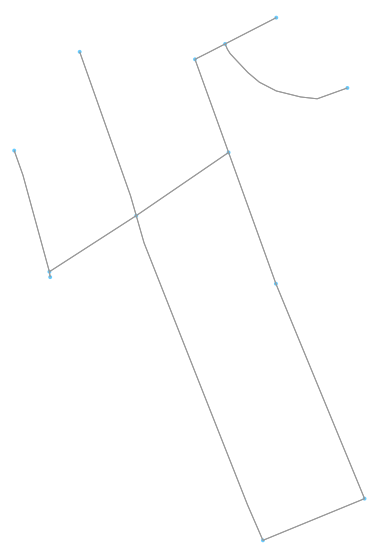

(<Figure size 619.923x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f445b1f1320>)

In [4]:
ox.plot_graph(bbox_graph, fig_height=10)

## In_out dictionary

The in_out dictionary is an intermediate representation of our graph for to allow easier computing of the desired graph. For every node, we simply list what nodes travel **in** to that node, and what nodes you can get to by traveling **out** of that node

In [5]:
from collections import defaultdict

In [6]:
def make_dict():
    return {'in':[],'out':[]}

In [7]:
in_out = defaultdict(make_dict)
for start, end in bbox_graph.edges():
    in_out[end]['in'].append(start)
    in_out[start]['out'].append(end)
in_out

defaultdict(<function __main__.make_dict()>,
            {63334966: {'in': [5441299616, 5441299617, 5441299823],
              'out': [5441299616, 5441299823, 5441299617]},
             5441299616: {'in': [63334966], 'out': [63334966]},
             5441299617: {'in': [63334966], 'out': [63334966]},
             5600335194: {'in': [5441299822, 5662408421],
              'out': [5441299822, 5662408421]},
             5441299822: {'in': [5441299823, 63334543, 5600335194],
              'out': [5600335194, 63334543, 5441299823]},
             63334543: {'in': [5441299822, 63327691],
              'out': [5441299822, 63327691]},
             5441299823: {'in': [5441299822, 5441299824, 5441299828, 63334966],
              'out': [5441299822, 63334966, 5441299824, 5441299828]},
             5441299824: {'in': [5441299823], 'out': [5441299823]},
             5441299828: {'in': [5441299823, 63327691],
              'out': [63327691, 5441299823]},
             63327691: {'in': [5441299828, 6333

## Connectivity 1

### Segments

In [40]:
segments = set()
nodes = set()
for k, v in in_out.items():
    for node in v['in']:
        n1 = (node, k, 'out')
        n2 = (k, node, 'in')
        nodes.add(n1)
        nodes.add(n2)
        segments.add((n1, n2))

### Intersections

In [42]:
intersections = set()
nodes = set()
for k, v in in_out.items():
    # every in connects to every out - unless same node
    for n_in in v['in']:
        n1 = (k, n_in, 'in')
        for n_out in v['out']:
            n2 = (k, n_out, 'out')
            
            intersections.add(n1)
            intersections.add(n2)
            
            if n_in != n_out:
                intersections.add((n1, n2))

In [43]:
intersections

{((5441299822, 5441299823, 'in'), (5441299822, 5600335194, 'out')),
 ((5441299822, 5441299823, 'in'), (5441299822, 63334543, 'out')),
 ((5441299822, 5600335194, 'in'), (5441299822, 5441299823, 'out')),
 ((5441299822, 5600335194, 'in'), (5441299822, 63334543, 'out')),
 ((5441299822, 63334543, 'in'), (5441299822, 5441299823, 'out')),
 ((5441299822, 63334543, 'in'), (5441299822, 5600335194, 'out')),
 ((5441299823, 5441299822, 'in'), (5441299823, 5441299824, 'out')),
 ((5441299823, 5441299822, 'in'), (5441299823, 5441299828, 'out')),
 ((5441299823, 5441299822, 'in'), (5441299823, 63334966, 'out')),
 ((5441299823, 5441299824, 'in'), (5441299823, 5441299822, 'out')),
 ((5441299823, 5441299824, 'in'), (5441299823, 5441299828, 'out')),
 ((5441299823, 5441299824, 'in'), (5441299823, 63334966, 'out')),
 ((5441299823, 5441299828, 'in'), (5441299823, 5441299822, 'out')),
 ((5441299823, 5441299828, 'in'), (5441299823, 5441299824, 'out')),
 ((5441299823, 5441299828, 'in'), (5441299823, 63334966, 'ou